# Reduced dynamics

This is a try to train the model with dynamics that have the reduced parameter dimensionality as in the Paper [Zuazua, Ruiz-, Momentum ResNet]

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
# seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

137



# Data preparation

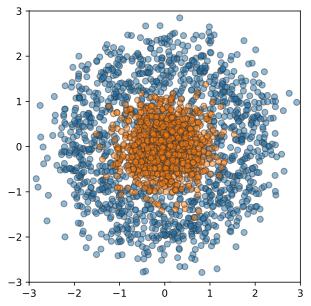

In [2]:
data_noise = 0.25
plotlim = [-3, 3]
subfolder = 'traj_circ'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('circles', noise = data_noise, plotlim = plotlim, random_state = seed)


## Model dynamics

In [3]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 20, 20 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside


## Training and generating level sets

In [4]:

num_epochs = 120 #number of optimization runs in which the dataset is used for gradient decent
eps = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
red_node = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy, reduced_dynamics=True)
optimizer_rnode = torch.optim.Adam(red_node.parameters(), lr=1e-3) 

In [5]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = eps) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/38
Loss: 3.003
Robust Term Loss: 0.007
Accuracy: 0.391

Iteration 10/38
Loss: 2.373
Robust Term Loss: 0.009
Accuracy: 0.422

Iteration 20/38
Loss: 1.947
Robust Term Loss: 0.004
Accuracy: 0.438

Iteration 30/38
Loss: 1.125
Robust Term Loss: 0.003
Accuracy: 0.578
Epoch 1: 1.812

Iteration 0/38
Loss: 0.955
Robust Term Loss: 0.004
Accuracy: 0.578

Iteration 10/38
Loss: 1.093
Robust Term Loss: 0.005
Accuracy: 0.359

Iteration 20/38
Loss: 0.767
Robust Term Loss: 0.004
Accuracy: 0.531

Iteration 30/38
Loss: 0.764
Robust Term Loss: 0.004
Accuracy: 0.547
Epoch 2: 0.872

Iteration 0/38
Loss: 0.824
Robust Term Loss: 0.004
Accuracy: 0.516

Iteration 10/38
Loss: 0.873
Robust Term Loss: 0.004
Accuracy: 0.500

Iteration 20/38
Loss: 0.743
Robust Term Loss: 0.003
Accuracy: 0.609

Iteration 30/38
Loss: 0.754
Robust Term Loss: 0.004
Accuracy: 0.547
Epoch 3: 0.750

Iteration 0/38
Loss: 0.792
Robust Term Loss: 0.003
Accuracy: 0.516

Iteration 10/38
Loss: 0.717
Robust Term Loss: 0.004
Accuracy:

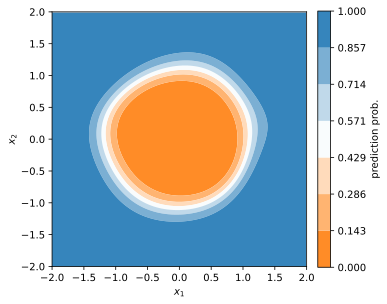

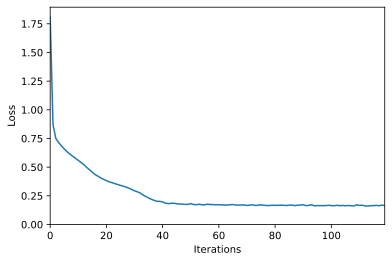

In [6]:
from plots.plots import classification_levelsets
classification_levelsets(anode)
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [7]:
   
w = anode.linear_layer.weight
b = anode.linear_layer.bias

print(w)
print(b)

red_node.linear_layer.weight = w
red_node.linear_layer.bias = b

red_node.linear_layer.requires_grad =  False

Parameter containing:
tensor([[-0.7766, -0.5448],
        [ 0.7195,  0.0130]], requires_grad=True)
Parameter containing:
tensor([-0.0480, -0.8414], requires_grad=True)


In [8]:
trainer_red_node = doublebackTrainer(red_node, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps) 
trainer_red_node.train(dataloader, num_epochs)


Iteration 0/38
Loss: 1.385
Robust Term Loss: 0.000
Accuracy: 0.531

Iteration 10/38
Loss: 1.379
Robust Term Loss: 0.000
Accuracy: 0.516

Iteration 20/38
Loss: 0.959
Robust Term Loss: 0.000
Accuracy: 0.656

Iteration 30/38
Loss: 1.220
Robust Term Loss: 0.000
Accuracy: 0.547
Epoch 1: 1.190

Iteration 0/38
Loss: 1.134
Robust Term Loss: 0.000
Accuracy: 0.469

Iteration 10/38
Loss: 1.023
Robust Term Loss: 0.000
Accuracy: 0.547

Iteration 20/38
Loss: 0.848
Robust Term Loss: 0.000
Accuracy: 0.672

Iteration 30/38
Loss: 0.747
Robust Term Loss: 0.000
Accuracy: 0.656
Epoch 2: 0.841

Iteration 0/38
Loss: 0.752
Robust Term Loss: 0.000
Accuracy: 0.641

Iteration 10/38
Loss: 0.703
Robust Term Loss: 0.000
Accuracy: 0.656

Iteration 20/38
Loss: 0.836
Robust Term Loss: 0.000
Accuracy: 0.531

Iteration 30/38
Loss: 0.679
Robust Term Loss: 0.000
Accuracy: 0.688
Epoch 3: 0.704

Iteration 0/38
Loss: 0.567
Robust Term Loss: 0.000
Accuracy: 0.672

Iteration 10/38
Loss: 0.623
Robust Term Loss: 0.000
Accuracy:

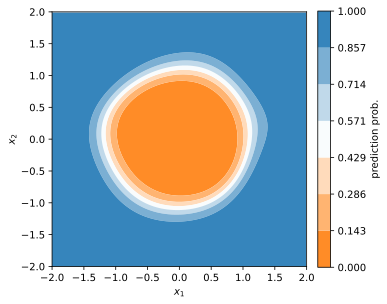

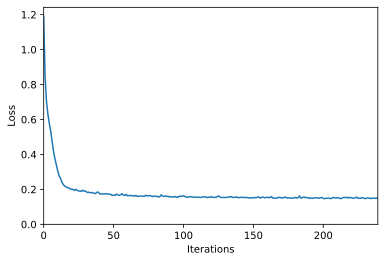

In [9]:
from plots.plots import classification_levelsets
classification_levelsets(anode)
plt.plot(trainer_red_node.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_red_node.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

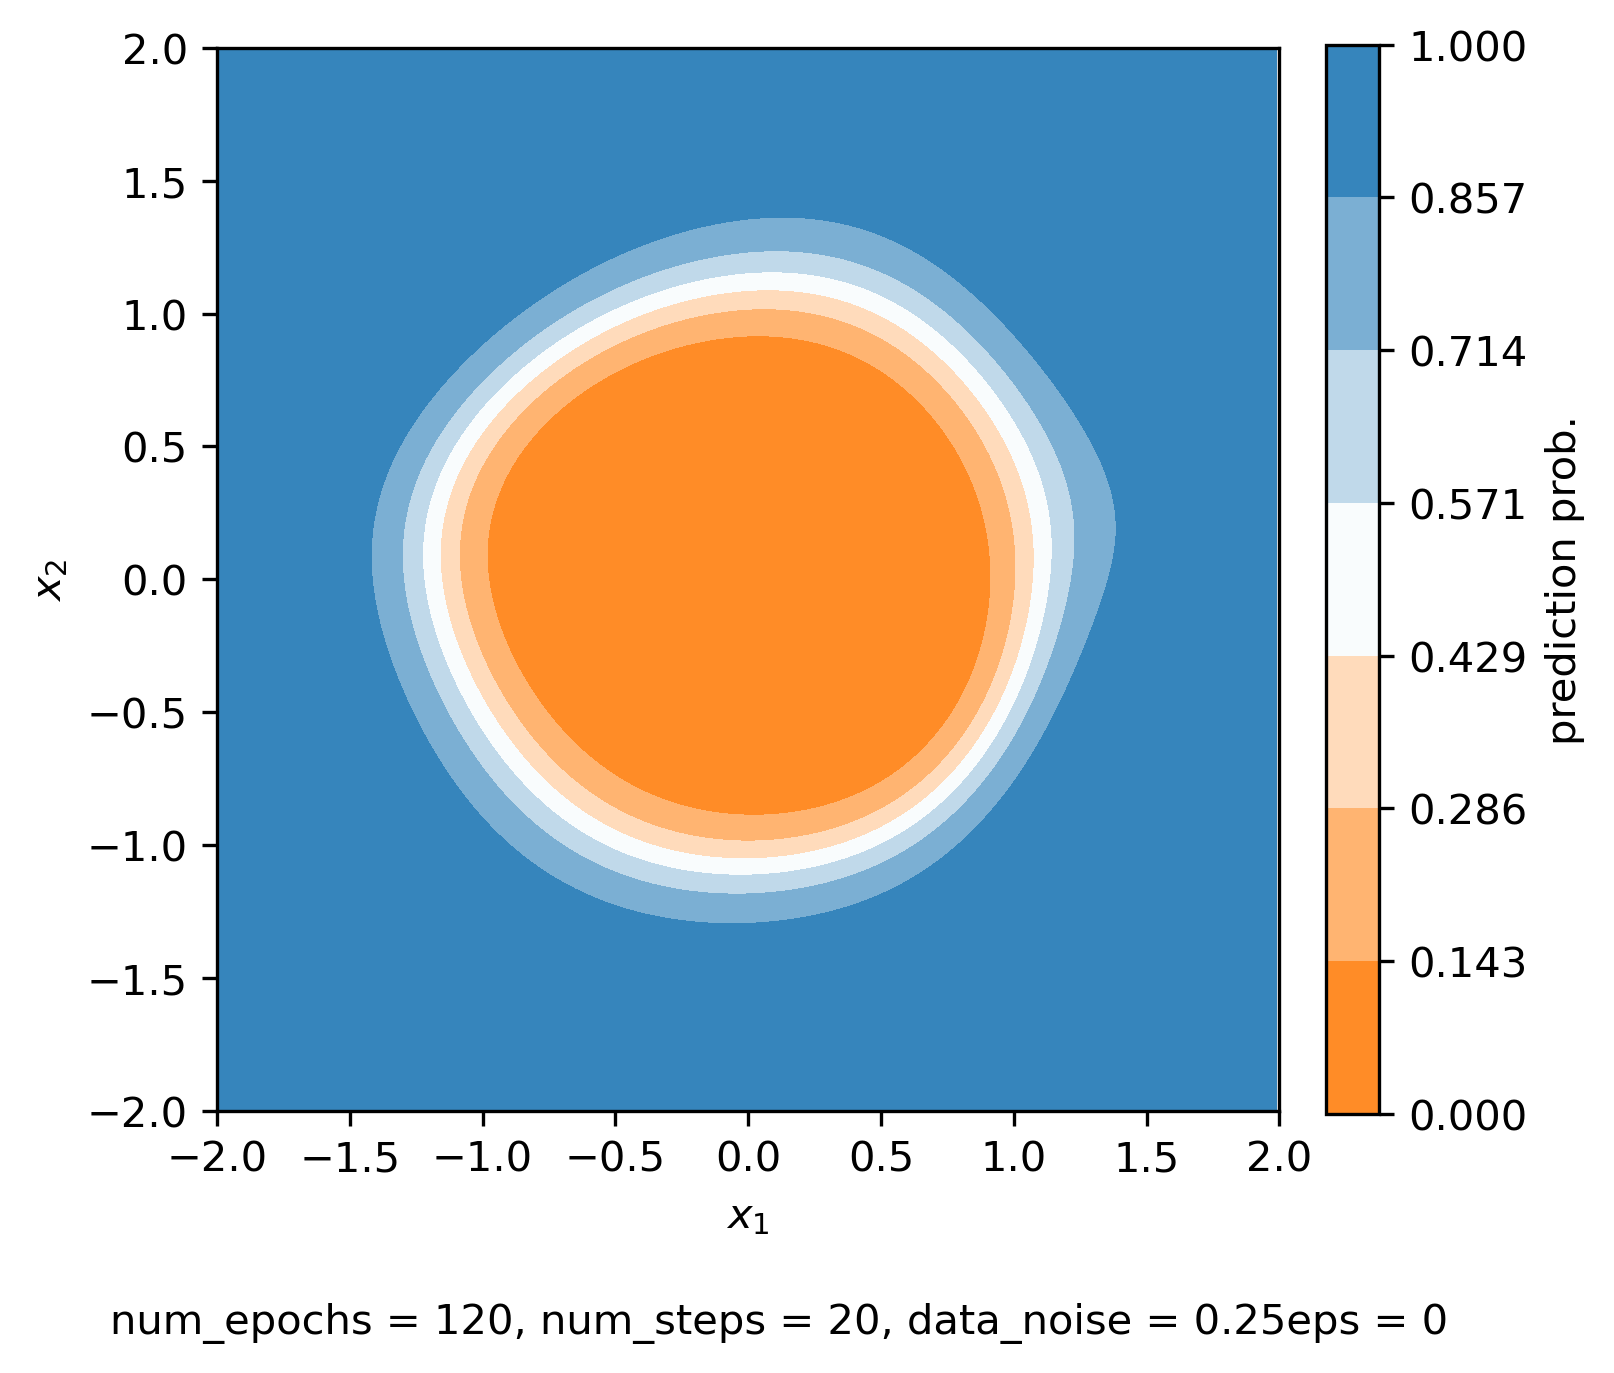

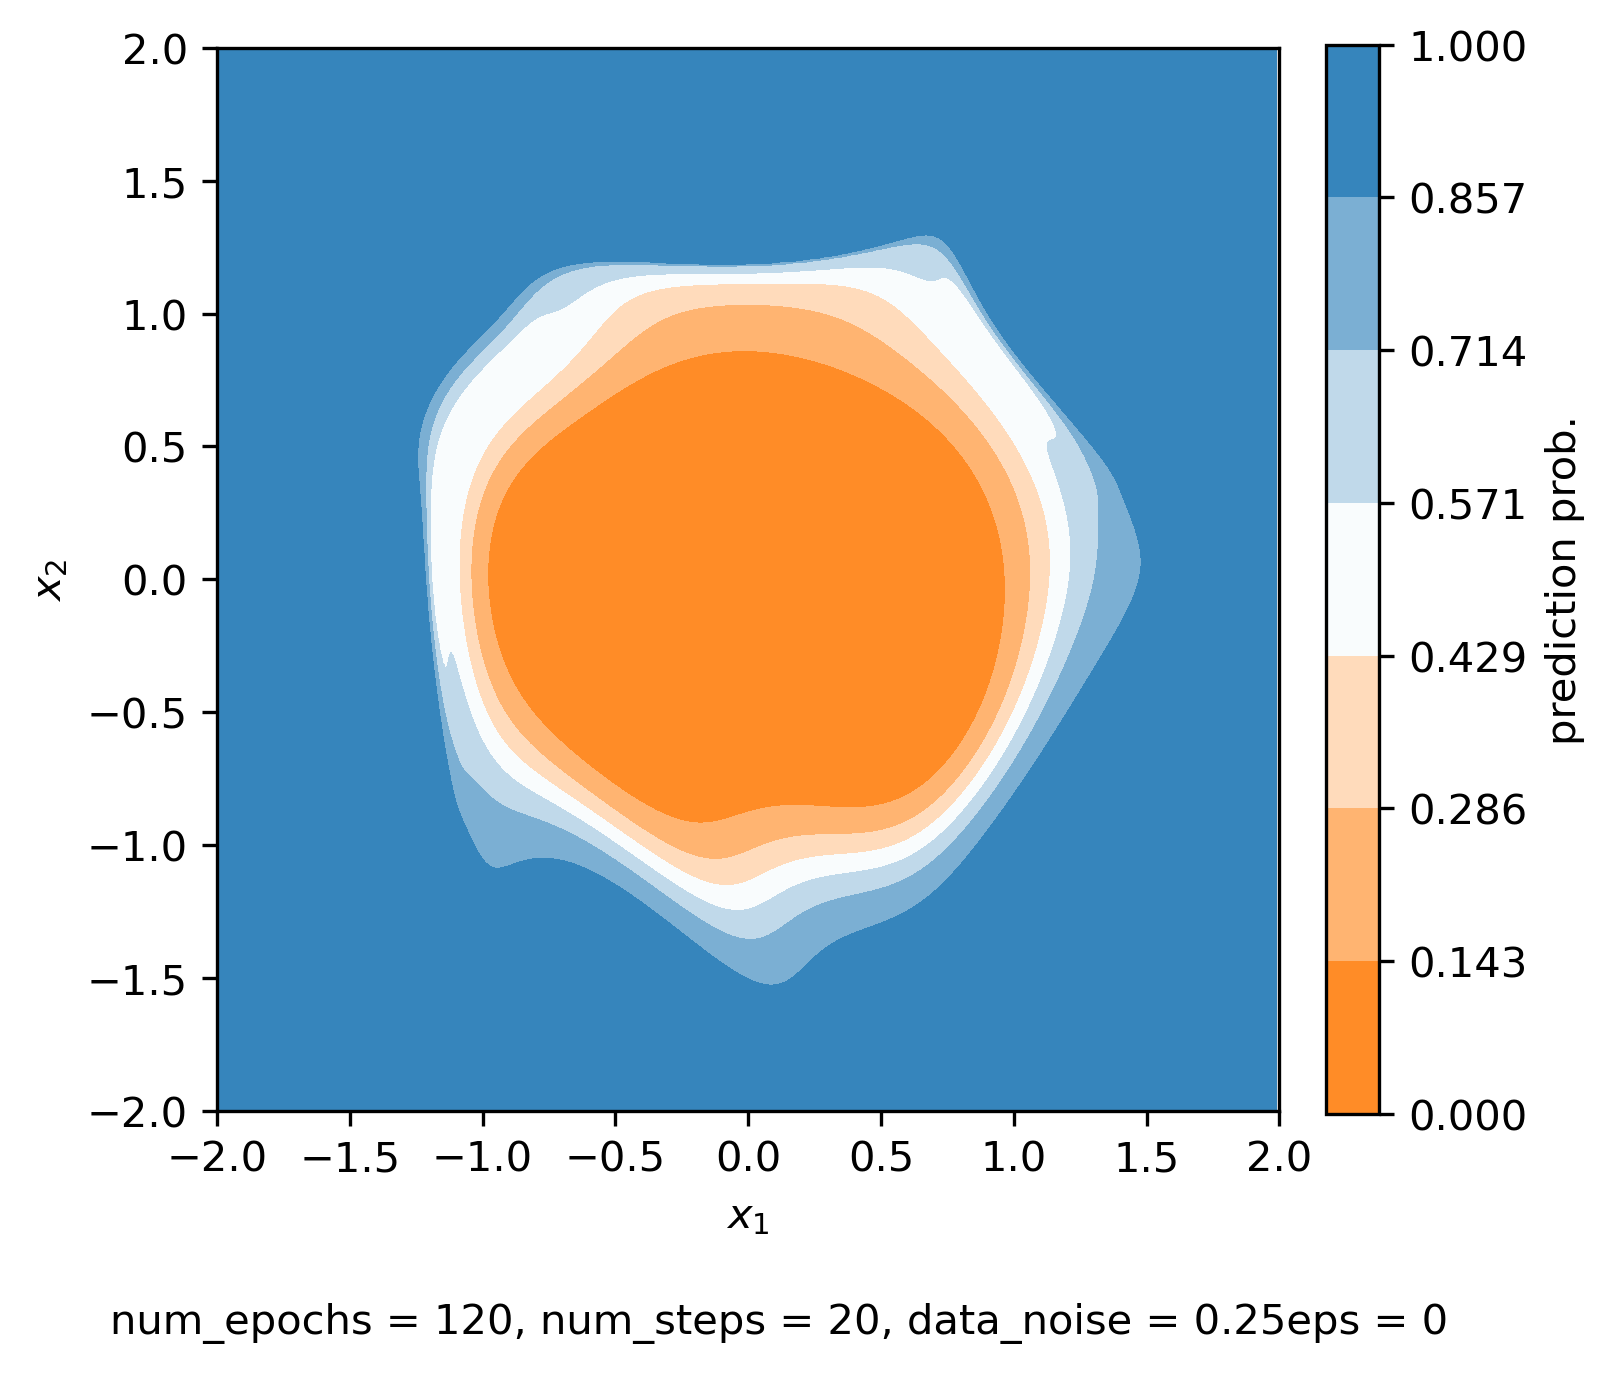

In [10]:
from plots.plots import classification_levelsets
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
footnote = f'{num_epochs = }, {num_steps = }, {data_noise = }'
        
fig_name_base = os.path.join(subfolder, 'levelsets')
classification_levelsets(anode, fig_name_base, footnote = footnote + 'eps = 0')
classification_levelsets(red_node, fig_name_base + '_red', footnote = footnote + f'{eps = }')
from IPython.display import Image
img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = fig_name_base + '_red.png', width = 400)

display(img1,img2)

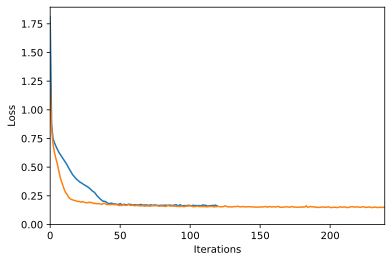

In [11]:
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')


plt.plot(trainer_red_node.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_red_node.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()